In [0]:
!nvidia-smi

## One-time installs

#### NVIDIA Apex

In [0]:
!git clone https://github.com/NVIDIA/apex
% cd apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
% cd /content

Cloning into 'apex'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 4788 (delta 76), reused 104 (delta 57), pack-reused 4636
Receiving objects: 100% (4788/4788), 8.79 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (3088/3088), done.
/content/apex
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:244: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-gbhdg0wf
Created temporary directory: /tmp/pip-req-tracker-h0xnepf7
Created requirements tracker '/tmp/pip-req-tracker-h0xnepf7'
Created temporary directory: /tmp/pip-install-af5hro52
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-y0sgka82
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-h0xnepf7'
  

#### BERT pretrained model repo (contains module for OpenAI GPT2)

In [0]:
! git clone https://github.com/epsdg/pytorch-pretrained-BERT

import sys
sys.path.insert(0, 'pytorch-pretrained-BERT')

! pip install regex

Cloning into 'pytorch-pretrained-BERT'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 3993 (delta 28), reused 29 (delta 15), pack-reused 3939
Receiving objects: 100% (3993/3993), 2.20 MiB | 12.43 MiB/s, done.
Resolving deltas: 100% (2760/2760), done.
     |████████████████████████████████| 655kB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


#### Pretrained model data

In [0]:
import os
import requests
from tqdm import tqdm

MODEL_SIZE = '345M' # medium

subdir = os.path.join('models', MODEL_SIZE)
if not os.path.exists(subdir):
    os.makedirs(subdir)
subdir = subdir.replace('\\','/') # needed for Windows

for filename in ['checkpoint','encoder.json','hparams.json','model.ckpt.data-00000-of-00001', 'model.ckpt.index', 'model.ckpt.meta', 'vocab.bpe']:

    r = requests.get("https://storage.googleapis.com/gpt-2/" + subdir + "/" + filename, stream=True)

    with open(os.path.join(subdir, filename), 'wb') as f:
        file_size = int(r.headers["content-length"])
        chunk_size = 1000
        with tqdm(ncols=100, desc="Fetching " + filename, total=file_size, unit_scale=True) as pbar:
            # 1k for chunk_size, since Ethernet packet size is around 1500 bytes
            for chunk in r.iter_content(chunk_size=chunk_size):
                f.write(chunk)
pbar.update(chunk_size)

! curl https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-medium-config.json --output '/content/models/345M/config.json'
! curl https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-medium-pytorch_model.bin --output '/content/models/345M/pytorch_model.bin'

! curl https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-medium-vocab.json --output '/content/models/345M/vocab.json'
! curl https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-medium-merges.txt --output '/content/models/345M/merges.txt'

Fetching checkpoint:   0%|                                              | 0.00/77.0 [00:00<?, ?it/s]
Fetching encoder.json:   0%|                                           | 0.00/1.04M [00:00<?, ?it/s]
Fetching hparams.json:   0%|                                            | 0.00/91.0 [00:00<?, ?it/s]
Fetching model.ckpt.data-00000-of-00001:   0%|                         | 0.00/1.42G [00:00<?, ?it/s]
Fetching model.ckpt.index:   0%|                                       | 0.00/10.4k [00:00<?, ?it/s]
Fetching model.ckpt.meta:   0%|                                         | 0.00/927k [00:00<?, ?it/s]
Fetching vocab.bpe:   0%|                                               | 0.00/456k [00:00<?, ?it/s]


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   293  100   293    0     0    813      0 --:--:-- --:--:-- --:--:--   816
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1449M  100 1449M    0     0  33.5M      0  0:00:43  0:00:43 --:--:-- 41.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1017k  100 1017k    0     0  1549k      0 --:--:-- --:--:-- --:--:-- 1546k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  445k  100  445k    0     0   732k      0 --:--:-- --:--:-- --:--:--  732k


## 2. Main routine

In [0]:
import os
import sys
import shutil
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import metrics
import logging
from datetime import datetime
import multiprocessing

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from apex import amp

import sys
sys.path.insert(0, 'pytorch-pretrained-BERT')

from pytorch_pretrained_bert import convert_gpt2_checkpoint_to_pytorch
from pytorch_pretrained_bert import GPT2Tokenizer
from pytorch_pretrained_bert import GPT2DoubleHeadsModel
from pytorch_pretrained_bert import OpenAIAdam
from pytorch_pretrained_bert import GPT2Config

print(f'n_cpus={multiprocessing.cpu_count()}')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device={device}, '+
      f'type: {torch.cuda.get_device_name(device)}, ' +
      f'CUDA capability: {torch.cuda.get_device_capability(device)}')

log_date = datetime.now().strftime('%m%d-%H%M')
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s: %(message)s',
                    datefmt='%H:%M:%S',
                    filename='/content/GPT2-345M-' + log_date + '.txt',
                    filemode='w')

logger1 = logging.getLogger('')

n_cpus=2
device=cuda, type: Tesla T4, CUDA capability: (7, 5)


#### Convert model to pytorch

In [0]:
MODEL_PATH = '/content/models/345M'

convert_gpt2_checkpoint_to_pytorch.convert_gpt2_checkpoint_to_pytorch(
    MODEL_PATH,
    MODEL_PATH + '/config.json',
    MODEL_PATH)

Converting TensorFlow checkpoint from /content/models/345M
Loading TF weight model/h0/attn/c_attn/b with shape [3072]
Loading TF weight model/h0/attn/c_attn/w with shape [1, 1024, 3072]
Loading TF weight model/h0/attn/c_proj/b with shape [1024]
Loading TF weight model/h0/attn/c_proj/w with shape [1, 1024, 1024]
Loading TF weight model/h0/ln_1/b with shape [1024]
Loading TF weight model/h0/ln_1/g with shape [1024]
Loading TF weight model/h0/ln_2/b with shape [1024]
Loading TF weight model/h0/ln_2/g with shape [1024]
Loading TF weight model/h0/mlp/c_fc/b with shape [4096]
Loading TF weight model/h0/mlp/c_fc/w with shape [1, 1024, 4096]
Loading TF weight model/h0/mlp/c_proj/b with shape [1024]
Loading TF weight model/h0/mlp/c_proj/w with shape [1, 4096, 1024]
Loading TF weight model/h1/attn/c_attn/b with shape [3072]
Loading TF weight model/h1/attn/c_attn/w with shape [1, 1024, 3072]
Loading TF weight model/h1/attn/c_proj/b with shape [1024]
Loading TF weight model/h1/attn/c_proj/w with s

#### Load & process data

In [0]:
def get_inputs(df_in, train_val_split):
    # Returns: train_texts, train_labels, val_texts, val_labels
    #    ( _texts: np.array of str )
    #    ( labels: np.array of np.int64 )

    # ...LOADER CODE...
    
    return train_texts, train_labels, val_texts, val_labels

train_texts, train_labels, val_texts, val_labels = get_inputs(train1, 0.8)

print(f'train records: {len(train_texts)} val records: {len(val_texts)}')

train records: 438223 val records: 109556


#### Hyperparameters

In [0]:
MAX_LEN = 128 # text sequences truncated to MAX_LEN-2 to accomodate special tokens
BATCH_SIZE = 8
N_EPOCHS = 1
ETA = 8e-6
OPTIMIZER_WARMUP = 0.05
GRAD_ACCUM_STEPS = 4 # gradient accumulation: step optimizer every # steps
AMP_OPT_LEVEL = 'O1' # https://nvidia.github.io/apex/amp.html#opt-levels
LM_COEFF = 0.01  # weighting for language modeling loss vs. classifier loss
LOG_INTERVAL = 500

#### Encode train data

In [0]:
SPECIAL_TOKENS = ['<BOS>', '<SEP>', '<CLS>']

tokenizer = GPT2Tokenizer.from_pretrained(MODEL_PATH,
                                               special_tokens=SPECIAL_TOKENS)

special_tokens_ids = list(tokenizer.convert_tokens_to_ids(token) for token in SPECIAL_TOKENS)

def encode(sentences, labels, tokenizer, max_len, special_tokens):
    assert len(sentences) == len(labels)
    n_records = len(sentences)

    input_ids = np.zeros((n_records, 1, max_len), dtype=np.int64)
    mc_token_ids = np.zeros((n_records, 1), dtype=np.int64)
    lm_labels = np.full((n_records, 1, max_len), fill_value=-1, dtype=np.int64)
    mc_labels = np.zeros((n_records, 1), dtype=np.int64)

    BOS, SEP, CLS = special_tokens

    for i, (sentence, label) in enumerate(tqdm(zip(sentences, labels),
                                               total=len(sentences),
                                               mininterval=10)):
 
        tokens = tokenizer.tokenize(sentence)[:max_len-2]

        indexed_tokens = tokenizer.convert_tokens_to_ids([BOS] + tokens + [CLS])
        input_ids[i, 0, :len(indexed_tokens)] = indexed_tokens
        mc_token_ids[i, 0] = len(indexed_tokens) - 1
        lm_labels[i, 0, :len(indexed_tokens)] = indexed_tokens

        mc_labels[i, 0] = label
        
    all_inputs = (input_ids, mc_token_ids, lm_labels, mc_labels)

    return tuple(torch.tensor(t) for t in all_inputs)


train_seqs = encode(train_texts,
                    train_labels,
                    tokenizer,
                    MAX_LEN,
                    SPECIAL_TOKENS)

train_ds = TensorDataset(*train_seqs)
train_sampler = RandomSampler(train_ds)

100%|██████████| 13146/13146 [00:06<00:00, 2064.90it/s]


#### Init model

In [0]:
device = torch.device('cuda')
model = GPT2DoubleHeadsModel.from_pretrained(MODEL_PATH,
                                                  num_special_tokens=len(SPECIAL_TOKENS))
model.to(device)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

#### Train

In [0]:
optimizer = OpenAIAdam(optimizer_grouped_parameters,
                       lr=ETA,
                       warmup=OPTIMIZER_WARMUP,
                       t_total=N_EPOCHS * np.ceil(len(train_texts) / BATCH_SIZE))

model, optimizer = amp.initialize(model, optimizer, opt_level=AMP_OPT_LEVEL, verbosity=1)

model = model.train()

lm_losses = []
clf_losses = []

model.zero_grad()

logger1.info(f'train hparams:\n   train recs: {len(train_texts):,}\n'
             + f'   max_len: {MAX_LEN}\n   n_epochs: {N_EPOCHS}\n'
             + f'   batch size: {BATCH_SIZE}\n   eta: {ETA}\n'
             + f'   accumulation steps: {GRAD_ACCUM_STEPS}\n'
             + f'   lm loss coeff: {LM_COEFF}\n   opt_level: {AMP_OPT_LEVEL}'
           )

for epoch in range(N_EPOCHS):
    train_loader = DataLoader(train_ds,
                              sampler=train_sampler,
                              batch_size=BATCH_SIZE)
    n_batches = len(train_loader)
    optimizer.zero_grad()
    tq = tqdm(train_loader, desc="Training", mininterval=30, maxinterval=60)

    for step, batch in enumerate(tq):

        batch = tuple(t.to(device) for t in batch)
        
        input_ids, mc_token_ids, lm_labels, mc_labels = batch

        lm_loss, clf_loss = model(input_ids, mc_token_ids,
                                  lm_labels,
                                  mc_labels=mc_labels)
                
        loss = (LM_COEFF * lm_loss.to(device) + clf_loss.to(device)).to(device)

        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()

        loss = loss.to(device)

        if (step+1) % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

        batch_lm_loss = lm_loss.item()
        batch_clf_loss = clf_loss.item()
        lm_losses.append(batch_lm_loss)
        clf_losses.append(batch_clf_loss)

        if (step+1) % LOG_INTERVAL == 0:
            clf_loss_mean = sum(clf_losses[(step+1-LOG_INTERVAL):]) / LOG_INTERVAL
            lm_loss_mean  = sum(lm_losses[(step+1-LOG_INTERVAL):]) / LOG_INTERVAL
            logstr = f'step {step+1} of {n_batches} clf_loss {clf_loss_mean:.4f} lm_loss {lm_loss_mean:.4f}'
            logger1.info(logstr)
            tq.set_postfix(lm_loss=lm_loss_mean, clf_loss=clf_loss_mean)

logger1.info('train complete.')

Training:   0%|          | 0/1644 [00:00<?, ?it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 256.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 128.0


Training:   5%|▍         | 80/1644 [00:30<09:55,  2.63it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 64.0


Training: 100%|██████████| 1644/1644 [10:49<00:00,  2.53it/s, clf_loss=0.545, lm_loss=7.34]


#### Save trained model
(optional)

In [0]:
SAVED_MODEL_FNAME = 'gpt2_345M_pytorch.bin'
SAVED_MODEL_DIR = '/content/saved_models'
if not os.path.exists(SAVED_MODEL_DIR):
    os.makedirs(SAVED_MODEL_DIR)

torch.save(model.state_dict(), os.path.join(SAVED_MODEL_DIR, SAVED_MODEL_FNAME))
logger1.info(f'Model saved as {SAVED_MODEL_DIR + "/" + SAVED_MODEL_FNAME}')

#### Plot losses

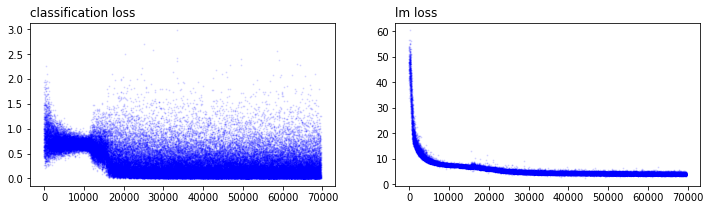

In [0]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 2, 1)
plt.plot(clf_losses, 'o', color='b', ms=1, alpha=0.1)
plt.title('classification loss', fontsize=12, loc='left')
ax = fig.add_subplot(1, 2, 2)
plt.plot(lm_losses, 'o', color='b', ms=1, alpha=0.1)
plt.title('lm loss', fontsize=12, loc='left');

#### Encode eval data

In [0]:
val_seqs = encode(val_texts,
                  val_labels,
                  tokenizer,
                  MAX_LEN,
                  SPECIAL_TOKENS)

val_ds = TensorDataset(*val_seqs)
val_sampler = SequentialSampler(val_ds)

val_loader = DataLoader(val_ds,
                        sampler=val_sampler,
                        batch_size=BATCH_SIZE)

100%|██████████| 3287/3287 [00:01<00:00, 2470.10it/s]


#### Load trained model
Skip this step if training and evaluating in the same runtime.

In [0]:
SAVED_MODEL_FNAME = 'gpt2_345M_pytorch.bin'
SAVED_MODEL_DIR = '/content/saved_models'
model.load_state_dict(torch.load(os.path.join(SAVED_MODEL_DIR, SAVED_MODEL_FNAME)))
logger1.info(f'Model loaded from {SAVED_MODEL_DIR + "/" + SAVED_MODEL_FNAME}')

#### Inference

In [0]:
model = model.to(device)

model.eval()

val_logits = []
val_preds = []

tq = tqdm(enumerate(val_loader), total=len(val_loader), mininterval=10)
for i, batch in tq:
    input_ids, mc_token_ids, _, _ = batch
    
    _, mc_logits_batch, _ = model(input_ids.to(device),
                                  mc_token_ids.to(device))
    
    preds_batch = torch.sigmoid(mc_logits_batch).to(device)
    preds_batch = preds_batch.detach().cpu().squeeze().tolist()
    
    val_preds.extend(preds_batch)

100%|██████████| 411/411 [00:51<00:00,  7.94it/s]


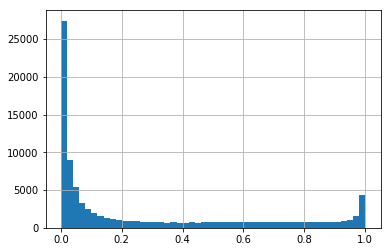

In [0]:
plt.hist(val_preds, bins=50)

#### Validation metrics

In [ ]:
val_preds = np.array(val_preds)
val_AUC = metrics.roc_auc_score(val_labels, val_preds)
val_acc = metrics.accuracy_score(val_labels.astype('int'), val_preds.astype('int'))
logger1.info(f'Eval set AUC = {val_AUC:.4f}')
logger1.info(f'Eval set accuracy = {val_acc:.4f}')
print(f'AUC {val_AUC:.4f}, acc {val_acc:.4f}')